In [1]:
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, AQGD, CG, GSLS
from qiskit.algorithms.optimizers import GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL
from qiskit.algorithms.optimizers import SLSQP, SPSA, QNSPSA, TNC, UMDA
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## Data loading

First, we load the corresponding dataset and extract the train and test splits

In [2]:
npz_dst = np.load('./data/CMAPSS_FD001_SENSOR_PCA.npz')

X_train, Y_train = npz_dst['X_train'], npz_dst['Y_train']
X_test, Y_test = npz_dst['X_test'], npz_dst['Y_test']


Then, depending on the computational resources and the complexity of the model training, we use the `train_test_split` to extract a portion of the dataset.

In [3]:
X_train, X_train_rest, Y_train, Y_train_rest = train_test_split(X_train, Y_train,
                                                  train_size=0.5, test_size=0.2,
                                                  random_state=0)

print( 'train split: {:d} samples'.format(X_train.shape[0]) )
print( '\ntrain rest split: {:d} samples'.format(X_train_rest.shape[0]) )


X_test, X_test_rest, Y_test, Y_test_rest = train_test_split(X_train, Y_train,
                                                  train_size=0.5, test_size=0.2,
                                                  random_state=0)


print( '\ntest split: {:d} samples'.format(X_test.shape[0]) )
print( '\ntest rest split: {:d} samples'.format(X_test_rest.shape[0]) )

train split: 10315 samples

train rest split: 4127 samples

test split: 5157 samples

test rest split: 2063 samples


## Model Building

First, based on the dataset shape, we define the FeatureMap and its number of qubits. On this step we used `RealAmplitudes`, `ZZFeatureMap`, `ZFeatureMap` or `RawFeatureVector`

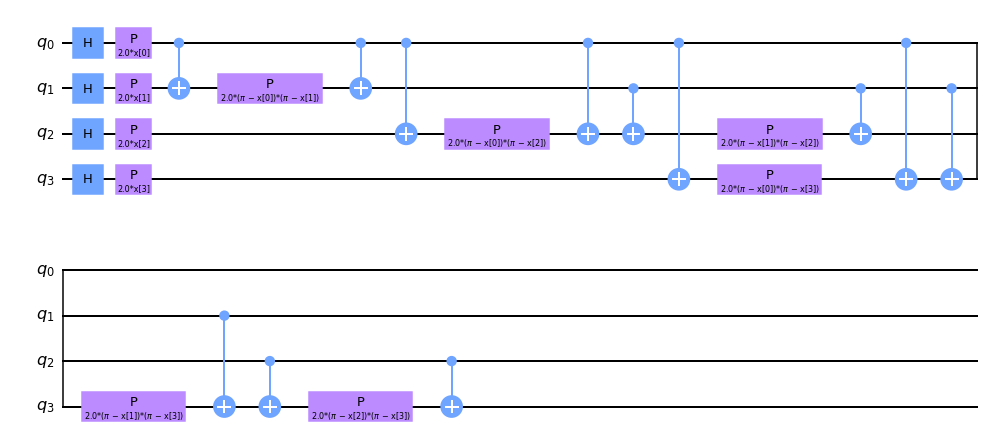

In [4]:
num_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)


Now we create the Ansatz. We define the number of the Ansatz repetitions using the `reps` parameter and the number of qubits equals to the output from the FeatureMap. Here we used `RealAmplitudes` or `EfficientSU2`

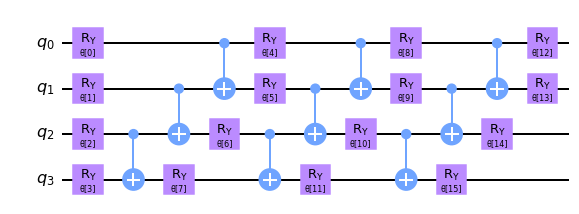

In [5]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

Now we construct the base quantum circuit that will be used for the QNN

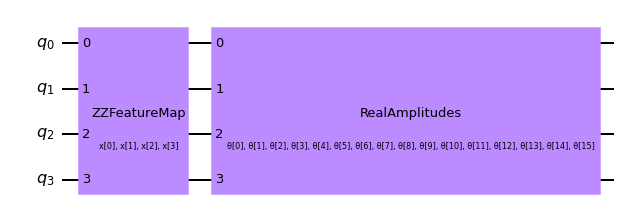

In [6]:
qc = QuantumCircuit(X_train.shape[1])
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

Then we choose an optimization algorithm to use in the training process. Here we used `COBYLA`, `SLSQP` or `SPSA`

In [7]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

We add a callback function called `callback_graph`. The model will call this function for each evaluation of the objective function with two parameters: the weights and the value of the objective function at those weights. This function will append the value of the objective function to an array in order to plot the iteration versus the objective function value, updating the plot at each iteration.

In [8]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Then we build the model. First, we construct the QNN and maps the network inputs to [-1 , +1].

In [9]:
from qiskit_machine_learning.neural_networks import EstimatorQNN


estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

estimator_qnn.forward(X_train[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.02519035]])

Then, we create the model

In [10]:
import time
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=optimizer, callback=callback_graph
)

## Model Training

Now, the training will be executed, using the previously built model and the callback function defined above.

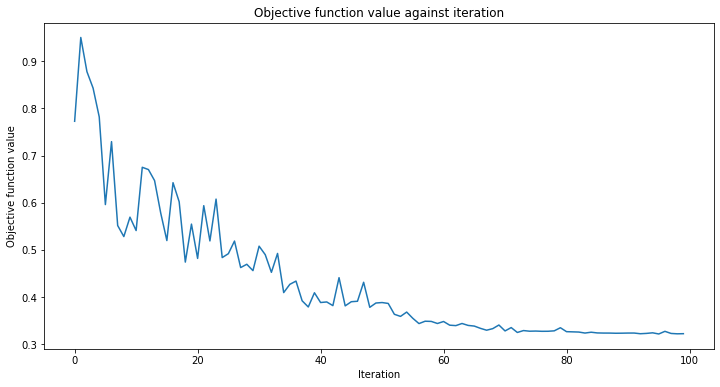

Training time: 61886 seconds


In [11]:
# clear objective value history
objective_func_vals = []

start = time.time()
estimator_classifier.fit(X_train, Y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

## Model Evaluation

Now we plot the respectives confusion matrices, we use the `scienceplot` style so first we have to import it. Then, we plot the matrix using the train dataset.

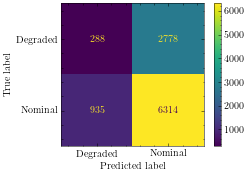

In [12]:
import scienceplots
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use('science')
Y_predict_train = estimator_classifier.predict(X_train)

# Confussion Matrix
cm_train = confusion_matrix(Y_train, Y_predict_train, labels=[0, 1])

# Plot Confussion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Degraded', 'Nominal'])
disp.plot()

# Save Confussion Matrix
name = "QNN_FD001_SENSOR_FEATURES_TRAIN_ZZFMP_RAMP_ESTIMATORQNN"
plt.savefig("../outputs/QNN/SENSOR/"+name+".pdf", format='pdf', bbox_inches='tight')

Then, with the test dataset.

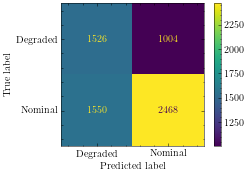

In [13]:
Y_predict_test = estimator_classifier.predict(X_test)

# Confussion Matrix
cm_test = confusion_matrix(Y_test, Y_predict_test, labels=[0, 1])

# Plot Confussion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Degraded', 'Nominal'])
disp.plot()

# Save Confussion Matrix
name = "QNN_FD001_SENSOR_FEATURES_TEST_ZZFMP_RAMP_ESTIMATORQNN"
plt.savefig("../outputs/QNN/SENSOR/"+name+".pdf", format='pdf', bbox_inches='tight')

Then we define a function to calculate more evaluation metrics.

In [14]:
def metrics(matrix):
    TP = matrix[0, 0]
    FP = matrix[0, 1]
    FN = matrix[1, 0]
    TN = matrix[1, 1]
    # Metrics calculation
    total = TP + FP + FN + TN
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    npv = TN / (TN + FN)

    # Print the results
    print(f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nSpecificity: {specificity:.2f}\nNPV: {npv:.2f}")

Now we evaluate how the quantum model performs on the used dataset.

In [15]:
train_score_q4 = estimator_classifier.score(X_train, Y_train)
test_score_q4 = estimator_classifier.score(X_test, Y_test)

print("Quantum VQC on the training dataset:")
print(f"Accuracy: {train_score_q4:.2f}")
metrics(cm_train)
print("\nQuantum VQC on the test dataset:")
print(f"Accuracy: {test_score_q4:.2f}")
metrics(cm_test)

Quantum VQC on the training dataset:
Accuracy: 0.64
Precision: 0.09
Recall: 0.24
Specificity: 0.69
NPV: 0.87

Quantum VQC on the test dataset:
Accuracy: 0.61
Precision: 0.60
Recall: 0.50
Specificity: 0.71
NPV: 0.61
